# Tutorial: Generating type Ia supernova lightcurves based on ztf_sim output 

This notebook shows how to load the output for Eric's survey simulator `ztf_sim` and generate SN Ia lightcurves using the SALT2 template. (Check out the other notebooks for examples how to simulate other transients.)

*Note:* You need to download Eric's newest sample output [here](https://drive.google.com/file/d/1sB6r21ALG7ZKetvE734JS-UpLa3iwWSz/view). The link was also included in Eric's email, so you will likely only need to change the path below.

Furthermore you'll require the dust map from Schlegel, Finkbeiner & Davis (1998) for full functionality. It can be found [here](https://github.com/kbarbary/sfddata/archive/master.tar.gz).

In [13]:
import os
home_dir = os.environ.get('HOME')

# Please enter the filename of the ztf_sim output file you would like to use. The example first determines
# your home directory and then uses a relative path (useful if working on several machines with different usernames)
survey_file = os.path.join(home_dir, 'data/ZTF/test_schedule_v6.db')

# Please enter the path to where you have placed the Schlegel, Finkbeiner & Davis (1998) dust map files
# You can also set the environment variable SFD_DIR to this path (in that case the variable below should be None)
sfd98_dir = os.path.join(home_dir, 'data/sfd98')

In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import simsurvey
import sncosmo
from astropy.cosmology import Planck15

from astropy import units as u
from astropy.coordinates import SkyCoord

import simsurvey_tools as sst 

In [15]:
# Load the ZTF CCD corners and filters
ccds = sst.load_ztf_ccds()
sst.load_ztf_filters()

Exception: ztfr already in registry. Use force=True to override.

In [ ]:
# Load simulated survey from file (download from ftp://ftp.astro.caltech.edu/users/ebellm/one_year_sim_incomplete.db)
# Currently DES filters are used as proxies for ZTF filters
plan = simsurvey.SurveyPlan(load_opsim=survey_file, band_dict={'g': 'ztfg', 'r': 'ztfr', 'i': 'desi'}, ccds=ccds)
                        
mjd_range = (plan.cadence['time'].min() - 30, plan.cadence['time'].max() + 30)

In [16]:
# To review the pointing schedule, you can use this table
plan.pointings

time,band,zp,skynoise,RA,Dec,field,comment
float64,str4,int64,float64,float64,float64,int64,str13
57433.16732874228,ztfr,30,1235.458254793129,97.27032,-24.25,258,all_sky
57433.167791705244,ztfr,30,1032.4155614033896,93.69218000000001,-17.05,307,all_sky
57433.16825466821,ztfr,30,831.1606554753829,96.84022,-9.85,358,all_sky
57433.16874926458,ztfr,30,768.014325534311,89.36968,4.55,459,all_sky
57433.16922019285,ztfr,30,754.6151413469311,85.58463,11.75,511,all_sky
57433.169683155815,ztfr,30,845.7393295485028,82.3588,4.55,458,all_sky
57433.170146118784,ztfr,30,754.6151413469311,85.58463,11.75,511,all_sky
57433.170609081746,ztfr,30,717.2561184374863,88.37309,18.95,562,nightly_plane
57433.171118378836,ztfr,30,666.0616637410405,91.24686,26.15,612,all_sky


## TransientGenerator
The transient generator combines a model and a distribution representing the transient population, and randomly draws all parameters needed to simulate the lightcurves. For well studied transient types, e.g. SNe Ia, models and generators have been predefined for easy use.

Here the maximum redshift has been kept very low in order make the simulation short. In reality $z_{max} = 0.2$ would be more realistic.

In [17]:
tr = simsurvey.get_transient_generator((0.0, 0.05),
                                       transient='Ia',
                                       template='salt2',
                                       dec_range=(-30,90),
                                       mjd_range=(mjd_range[0],
                                                  mjd_range[1]),
                                       sfd98_dir=sfd98_dir)

## SimulSurvey
Lastly, all parts are combined in a SimulSurvey object that will generate the lightcurves.
(This may take about a minute or two.)

In [18]:
survey = simsurvey.SimulSurvey(generator=tr, plan=plan)
    
lcs = survey.get_lightcurves(
    #progress_bar=True, notebook=True # If you get an error because of the progress_bar, delete this line.
)

/home/hegoo/anaconda3/lib/python3.5/site-packages/simsurvey/simulsurvey.py:1356: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(max_flux) + zp


In [19]:
len(lcs.lcs)

389

In [20]:
lc=lcs[30]

{'x1': 2.399933935925768, 'x0': 0.0015498579328701028, 'mwebv': 0.625845108001391, 't0': 57705.72599568062, 'c': 0.1359284952764266, 'z': 0.04836632327693597, 'dec': 44.34807204522328, 'idx_orig': 61, 'mwebv_sfd98': 0.6339222377086363, 'stats': {'p_last': 0.6885817177317222, 'p_det': -16.354453980085964, 'dt_det': 0.026664787299523596, 'p_binned': {'ztfr': array([ 0., 14., 24., 12., 24., 17.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.]), 'desi': array([0., 4., 8., 4., 3., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]), 'ztfg': array([0., 7., 6., 4., 8., 6., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]), 'all': array([ 0, 25, 38, 20, 35, 25,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0])}, 'mag_max': {'ztfr': 18.90665967630833, 'desi': 19.1967218193784, 'ztfg': 19.634002901000972}}, 'ra': 67.42725236665761}
This is the position 67.42725236665761 44.34807204522328
cut this 2.5370924519723963
This is 

This is the position 67.42725236665761 44.34807204522328
cut this 14.667633178020447
This is the position 67.42725236665761 44.34807204522328
cut this 42.8974733636536
This is the position 67.42725236665761 44.34807204522328
cut this -1.7983317540753658
This is the position 67.42725236665761 44.34807204522328
cut this 14.063013093330996
This is the position 67.42725236665761 44.34807204522328
cut this -11.597382342553807
This is the position 67.42725236665761 44.34807204522328
cut this 31.801721110690163
This is the position 67.42725236665761 44.34807204522328
cut this 22.993884201468912
This is the position 67.42725236665761 44.34807204522328
cut this 48.53576047001776
This is the position 67.42725236665761 44.34807204522328
cut this 25.33686013187466
This is the position 67.42725236665761 44.34807204522328
we are going to keep this 72.5484643731093
This is the position 67.42725236665761 44.34807204522328
cut this 22.98386427164552
This is the position 67.42725236665761 44.34807204522

This is the position 67.42725236665761 44.34807204522328
cut this 40.68855659538998
This is the position 67.42725236665761 44.34807204522328
cut this -2.3276921860270483
This is the position 67.42725236665761 44.34807204522328
we are going to keep this 62.08151084765867
This is the position 67.42725236665761 44.34807204522328
cut this 51.93529686970285
This is the position 67.42725236665761 44.34807204522328
cut this 34.73023939163504
This is the position 67.42725236665761 44.34807204522328
we are going to keep this 75.88599452032639
This is the position 67.42725236665761 44.34807204522328
we are going to keep this 60.44852227174448
This is the position 67.42725236665761 44.34807204522328
we are going to keep this 60.38437358265284
This is the position 67.42725236665761 44.34807204522328
cut this 7.403199974310179
This is the position 67.42725236665761 44.34807204522328
cut this 35.93988853640412
This is the position 67.42725236665761 44.34807204522328
cut this 14.265287400729052
This 

This is the position 67.42725236665761 44.34807204522328
cut this 27.167269295216023
This is the position 67.42725236665761 44.34807204522328
cut this 26.316811236094477
This is the position 67.42725236665761 44.34807204522328
cut this 55.62868824151324
This is the position 67.42725236665761 44.34807204522328
cut this 11.829775927033252
This is the position 67.42725236665761 44.34807204522328
cut this 38.202041333358814
This is the position 67.42725236665761 44.34807204522328
cut this 30.46817829672129
This is the position 67.42725236665761 44.34807204522328
cut this 32.540560193904646
This is the position 67.42725236665761 44.34807204522328
cut this -18.228233911677417
This is the position 67.42725236665761 44.34807204522328
cut this -3.4030738581056856
This is the position 67.42725236665761 44.34807204522328
cut this -5.756201644666397
This is the position 67.42725236665761 44.34807204522328
cut this 1.0335157509554822
This is the position 67.42725236665761 44.34807204522328
cut this

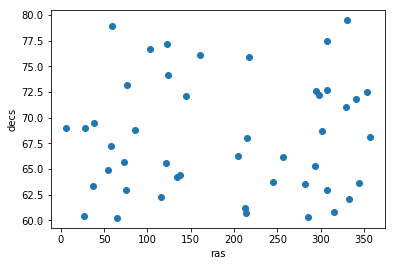

In [21]:
print( lc.meta )
newlcs = []
ra, dec = lc.meta['ra'], lc.meta['dec']

for lc in lcs:
    print("This is the position %s %s"%(ra, dec))                                               
    if lc.meta['dec']<60:
        print ("cut this", lc.meta['dec'])
    else:
        print("we are going to keep this", lc.meta['dec'])
        #ras = [lc.meta["ra"]for lc in newlcs]
        #decs = [lc.meta["dec"]for lc in newlcs]
        newlcs.append(lc)

decs = [lc.meta["dec"]for lc in newlcs]
ras =  [lc.meta["ra"]for lc in newlcs]


plt.plot(ras,decs,'o')
plt.xlabel('ras')
plt.ylabel('decs')


plt.show()







## Analysing the output

The output of `get_lightcurves()` is a `LightcurveCollection` object. Lightcurves are automatically filter, so only those that would be detected in the survey are kept.

You can save a the lightcurves in a pickle file and load them again later without rerunning the simulation.

In [22]:
lcs.save('lcs_tutorial.pkl')

In [23]:
lcs = simsurvey.LightcurveCollection(load='lcs_tutorial.pkl')

EOFError: Ran out of input

You can inspect the lightcurves manually. This example should return the lightcurve with the most points with S/N > 5.

In [ ]:
_ = sncosmo.plot_lc(lcs[0])

The two figures below show how early the MNe are detected and at what redshifts. The simulation input parameters of transients that were not detected are also kept, so can check completeness. 

In [ ]:
plt.hist(lcs.stats['p_det'], lw=2, histtype='step', range=(-20,0), bins='auto', color='red')
plt.xlabel('Detection phase (observer-frame)', fontsize='x-large')
_ = plt.ylabel(r'$N_{SNe}$', fontsize='x-large')



In [ ]:
a = plt.hist(lcs.meta_full['z'], lw=1, histtype='step', range=(0,0.05), bins=151, label='all')
b = plt.hist(lcs.meta['z'], lw=2, histtype='step', range=(0,0.05), bins=151, label='detected')
plt.xlabel('Redshift', fontsize='x-large')
plt.ylabel(r'$N_{SNe}$', fontsize='x-large')
plt.xlim((0, 0.05))
plt.legend()


#pickle.dump(obj, file, protocol=None, *, fix_imports=True)¶

#len(b)
#print(b[0],len(b[0]))
#print(b[1],len(b[1]))

#out=[]
#out.append(a[0])
#out.append(a[1][:-1])
#np.savetxt("vel.txt",np.asarray(out).T)
#np.savetxt("vel1.txt",np.asarray(out).T)
#np.savetxt("vel1.txt1", DAT, delimiter=" ", fmt="%s") 
#import pickle
#pickle.dump(a,open("vel.pkl","wb"))
#a=pickle.load(open("vel.pkl","rb"))
out=[]
out.append(a[0])
out.append(a[1][:-1])
#out=[]
#out.append(b[0])
#out.append(b[1][:-1])
np.savetxt("veltoday.txt",np.asarray(out).T)

In [ ]:
def functionname( parameters ):
   "function_docstring"
   function_suite
   return [expression]


In [ ]:
def parse_lcs(lcs,geometry,geometryargs):
    if geometry=="bands":
        parsed_lcs = parse_lcs(lcs,"bands",20,5)
    print ("parse_lcs")

In [ ]:
lc=lcs[10]